# Исследование и оценка методов и архитектур на задаче детекции дорожных знаков

## Установка MMDetection

In [1]:
!nvcc -V
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [58]:
!pip install torch
!pip install roboflow
!pip install imagesize

In [3]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
%pip install -U openmim
!mim install "mmengine>=0.7.0"
!mim install "mmcv>=2.0.0rc4, <2.2.0"

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

%pip install -e .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 5.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.9 MB/s eta 0

In [93]:
import numpy as np
import pandas as pd
import json
import os
import imagesize
from tqdm.auto import tqdm
from skmultilearn.model_selection import IterativeStratification

## Подготовка данных

In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="uiYw4hncK5TJCDrBbCuS")
project = rf.workspace("kumaraguru-college-of-technology-gfdmc").project("raccoons-elprc")
dataset = project.version(2).download("coco-mmdetection")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Raccoons-2 in coco-mmdetection:: 100%|██████████| 504/504 [00:00<00:00, 3632.27it/s]


In [5]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir ./checkpoints
!mim download mmdet --config atss_r50_fpn_1x_coco --dest ./checkpoints

processing atss_r50_fpn_1x_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 MiB 35.3 MB/s eta 0:00:0000:0100:01
Successfully downloaded atss_r50_fpn_1x_coco_20200209-985f7bd0.pth to /kaggle/working/mmdetection/checkpoints
Successfully dumped atss_r50_fpn_1x_coco.py to /kaggle/working/mmdetection/checkpoints


In [90]:
dataset_path = "/kaggle/input/rtsd-small"
anno_path = dataset_path + "/full_gt_reduced.csv"
image_path = dataset_path + "/rtsd-dataset-reduced/rtsd-dataset-reduced/rtsd-frames/"
label_map = dataset_path + "/rtsd-dataset-reduced/rtsd-dataset-reduced/label_map.json"

with open(label_map, 'r') as f:
    label_map = json.load(f)
    label_map = {k: v for k, v in label_map.items()}
    categories = [{"id": v, "name": k} for k, v in label_map.items()]

class_to_color = [tuple(np.random.choice(range(256), size=3)) for _ in range(len(label_map))]

df = pd.read_csv(anno_path)

# Фильтруем отсутствующие классы
df = df[df["sign_class"].isin(label_map.keys())]

# Переводим колонки координат в списки
df['bbox'] = df[['x_from', 'y_from', 'width', 'height']].apply(lambda row: [row['x_from'], row['y_from'], row['width'], row['height']], axis=1)

# Переводим названия знаков в их индексы
df['sign_class'] = df[['sign_class']].apply(lambda row: label_map[row['sign_class']], axis=1)

# Удаляем ненужные колонки
df = df.drop(
    columns=["Unnamed: 0", "is_train", 'x_from', 'y_from', 'width', 'height', "sign_id"],
    errors="ignore"
)

df = df.rename(columns={"sign_class": "category_id", "filename": "file_name"})

# Группируем разметку нескольких знаков в одну запись
df = df.groupby('file_name').agg({
    'category_id': lambda x: list(x),
    'bbox': lambda x: list(x)
}).reset_index()

df["image_id"] = range(len(df))

def stratified_train_test_split(df, test_size=0.3, random_state=None):
    # Create multi-hot encoded labels
    all_sign_ids = sorted(set(sign_id for sublist in df['category_id'] for sign_id in sublist))
    y = np.zeros((len(df), len(all_sign_ids)), dtype=int)
    
    for i, sign_ids in enumerate(df['category_id']):
        for sign_id in sign_ids:
            col_idx = all_sign_ids.index(sign_id)
            y[i, col_idx] = 1

    stratifier = IterativeStratification(
        n_splits=2,
        order=1,
        sample_distribution_per_fold=[1-test_size, test_size],
        random_state=random_state
    )
    test_indices, train_indices = next(stratifier.split(df.index.values, y))

    return df.iloc[train_indices], df.iloc[test_indices]

In [151]:
os.chdir('/kaggle/working/')

df_train, df_valid = stratified_train_test_split(df, test_size=0.3, random_state=None)
df_valid, df_test = stratified_train_test_split(df, test_size=0.3, random_state=None)

idx_start = 0
for df_part, name in zip((df_train, df_valid, df_test), ("train", "valid", "test")):
    print(name)
    df_part = df_part.explode(['category_id', 'bbox']).reset_index(drop=True)

    df_part["id"] = range(idx_start, idx_start+len(df_part))
    idx_start += len(df_part)

    df_part["id"] = df_part["id"].astype(int)
    
    df_part["iscrowd"] = [0]*len(df_part)
    df_part["area"] = df_part[['bbox']].apply(lambda row: row['bbox'][2] * row['bbox'][3], axis=1)
    
    annotations = df_part.to_dict(orient='records')
    
    images = []
    for idx, row in df_part.iterrows():
        width, height = imagesize.get(image_path + row["file_name"])
        bbox_w, bbox_h = row["bbox"][2:]
        images.append({
            "id": row["image_id"],
            "license": 1,
            "file_name": row["file_name"],
            "width": width,
            "height": height,
            "area": bbox_w * bbox_h,
            "date_captured": "2023-12-15T15:20:35+00:00",
            
        })
    
    anno_part = {
        "info": {
            "year": "2023",
            "version": "2",
            "description": "Exported from roboflow.com",
            "contributor": "",
            "url": "https://public.roboflow.com/object-detection/undefined",
            "date_created": "2023-12-15T15:20:35+00:00"
        },
        "licenses": [
            {
                "id": 1,
                "url": "https://creativecommons.org/licenses/by/4.0/",
                "name": "CC BY 4.0"
            }
        ],
        "categories": categories,
        "images": images,
        "annotations": annotations
    }

    
    
    with open(f'{name}.json', 'w') as fp:
        json.dump(anno_part, fp, cls=NpEncoder)

train


KeyboardInterrupt: 

In [148]:
print(df_test.shape)
df_test

(692, 4)


,file_name,category_id,bbox,image_id
0,autosave01_02_2012_09_16_49.jpg,[11],"[[826, 277, 37, 49]]",0
2,autosave01_02_2012_09_16_51.jpg,[11],"[[1117, 90, 81, 107]]",2
6,autosave01_02_2012_09_17_05.jpg,"[12, 13, 14, 7]","[[908, 179, 82, 78], [752, 275, 20, 24], [756,...",6
7,autosave01_02_2012_09_17_08.jpg,"[13, 14, 7]","[[794, 178, 37, 37], [805, 237, 38, 38], [951,...",7
9,autosave01_02_2012_09_18_35.jpg,"[1, 19]","[[697, 276, 41, 42], [706, 348, 32, 17]]",9
...,...,...,...,...
2297,autosave24_10_2013_11_35_18_1.jpg,[116],"[[705, 351, 61, 29]]",2297
2307,autosave24_10_2013_11_40_31_2.jpg,[116],"[[629, 386, 31, 16]]",2307
2309,autosave24_10_2013_11_42_25_1.jpg,[23],"[[708, 365, 27, 25]]",2309
2311,autosave24_10_2013_11_44_01_2.jpg,[116],"[[669, 364, 45, 22]]",2311


In [159]:
os.chdir('/kaggle/working/mmdetection')

config_balloon = """
# Inherit and overwrite part of the config based on this config
_base_ = './atss_r50_fpn_1x_coco.py'

data_root = '/kaggle/input/rtsd-small' # dataset root

train_batch_size_per_gpu = 4
train_num_workers = 4

max_epochs = 4
stage2_num_epochs = 1
base_lr = 0.001

classes = ('2_1', '1_23', '1_17', '3_24', '8_2_1', '5_20', '5_19_1', '5_16', '3_25', '6_16', '7_15', '2_2', '2_4', '8_13_1', '4_2_1', '1_20_3', '1_25', '3_4', '8_3_2', '3_4_1', '4_1_6', '4_2_3', '4_1_1', '1_33', '5_15_5', '3_27', '1_15', '4_1_2_1', '6_3_1', '8_1_1', '6_7', '5_15_3', '7_3', '1_19', '6_4', '8_1_4', '8_8', '1_16', '1_11_1', '6_6', '5_15_1', '7_2', '5_15_2', '7_12', '3_18', '5_6', '5_5', '7_4', '4_1_2', '8_2_2', '7_11', '1_22', '1_27', '2_3_2', '5_15_2_2', '1_8', '3_13', '2_3', '8_3_3', '2_3_3', '7_7', '1_11', '8_13', '1_12_2', '1_20', '1_12', '3_32', '2_5', '3_1', '4_8_2', '3_20', '3_2', '2_3_6', '5_22', '5_18', '2_3_5', '7_5', '8_4_1', '3_14', '1_2', '1_20_2', '4_1_4', '7_6', '8_1_3', '8_3_1', '4_3', '4_1_5', '8_2_3', '8_2_4', '1_31', '3_10', '4_2_2', '7_1', '3_28', '4_1_3', '5_4', '5_3', '6_8_2', '3_31', '6_2', '1_21', '3_21', '1_13', '1_14', '2_3_4', '4_8_3', '6_15_2', '2_6', '3_18_2', '4_1_2_2', '1_7', '3_19', '1_18', '2_7', '8_5_4', '5_15_7', '5_14', '5_21', '1_1', '6_15_1', '8_6_4', '8_15', '4_5', '3_11', '8_18', '8_4_4', '3_30', '5_7_1', '5_7_2', '1_5', '3_29', '6_15_3', '5_12', '3_16', '1_30', '5_11', '1_6', '8_6_2', '6_8_3', '3_12', '3_33', '8_4_3', '5_8', '8_14', '8_17', '3_6', '1_26', '8_5_2', '6_8_1', '5_17', '1_10', '8_16', '7_18', '7_14', '8_23')

# Generate a proper palette with different colors for each class
import random
random.seed(42)  # For reproducible colors

def generate_palette(num_classes):
    palette = []
    for i in range(num_classes):
        # Generate distinct colors using HSV color space
        import colorsys
        hue = i / num_classes
        saturation = 0.7 + 0.3 * (i % 2)  # Alternate between high and higher saturation
        value = 0.8 + 0.2 * ((i + 1) % 2)  # Alternate between high and higher value
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        palette.append(tuple(int(c * 255) for c in rgb))
    return palette

palette = generate_palette(len(classes))

metainfo = {
    'classes': classes,
    'palette': palette,
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img=data_root+'/rtsd-dataset-reduced/rtsd-dataset-reduced/rtsd-frames/'),
        ann_file='/kaggle/working/train.json'))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img=data_root+'/rtsd-dataset-reduced/rtsd-dataset-reduced/rtsd-frames/'),
        ann_file='/kaggle/working/valid.json'))

test_dataloader =  dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img=data_root+'/rtsd-dataset-reduced/rtsd-dataset-reduced/rtsd-frames/'),
        ann_file='/kaggle/working/test.json'))

val_evaluator = dict(ann_file='/kaggle/working/valid.json')

test_evaluator = dict(ann_file='/kaggle/working/test.json')

model = dict(bbox_head=dict(num_classes=len(classes)))

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        # use cosine lr from 10 to 20 epoch
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='Resize',
        scale=(640, 640)
    ),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    checkpoint=dict(
        interval=5,
        max_keep_ckpts=2,  # only keep latest 2 checkpoints
        save_best='auto'
    ),
    logger=dict(type='LoggerHook', interval=5))

custom_hooks = [
    dict(
        type='PipelineSwitchHook',
        switch_epoch=max_epochs - stage2_num_epochs,
        switch_pipeline=train_pipeline_stage2)
]

# load COCO pre-trained weight
load_from = './checkpoints/atss_r50_fpn_1x_coco_20200209-985f7bd0.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'),dict(type='TensorboardVisBackend')])
"""

with open('/kaggle/working/mmdetection/configs/atss/atss_r50_fpn_1x_raccoon.py', 'w') as f:
    f.write(config_balloon)

In [160]:
!python tools/train.py /kaggle/working/mmdetection/configs/atss/atss_r50_fpn_1x_raccoon.py

2025-07-13 16:56:50.568071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752425810.590307    2402 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752425810.597128    2402 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
07/13 16:56:53 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1258111586
    GPU 0,1: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.5, V12.5.82
    GCC: x86_64-linux-gnu-gcc (Ubuntu 

In [161]:
import os
os.environ['TORCH_FORCE_WEIGHTS_ONLY_LOAD'] = 'false'

In [162]:
# Method 1: Direct torch.load patching (fixed recursion issue)
import torch
import functools

# Store the original torch.load function using functools to avoid recursion
original_torch_load = torch.load

def patched_torch_load(f, map_location=None, pickle_module=None, weights_only=None, **kwargs):
    """Patched torch.load that forces weights_only=False for .pth files"""
    if isinstance(f, str) and f.endswith('.pth'):
        # Force weights_only=False for checkpoint files
        # Use __wrapped__ to get the original function if it exists, otherwise use the stored original
        if hasattr(original_torch_load, '__wrapped__'):
            return original_torch_load.__wrapped__(f, map_location=map_location, pickle_module=pickle_module, weights_only=False, **kwargs)
        else:
            # Directly call the original function we stored
            return torch.serialization.load(f, map_location=map_location, pickle_module=pickle_module, weights_only=False, **kwargs)
    else:
        # Use original behavior for other files
        if hasattr(original_torch_load, '__wrapped__'):
            return original_torch_load.__wrapped__(f, map_location=map_location, pickle_module=pickle_module, weights_only=weights_only, **kwargs)
        else:
            return torch.serialization.load(f, map_location=map_location, pickle_module=pickle_module, weights_only=weights_only, **kwargs)

# Apply the patch globally
torch.load = patched_torch_load

print("Torch.load patched successfully - weights_only=False for .pth files")

# Now import and use MMDetection normally
from mmdet.apis import DetInferencer
import glob

# Choose to use a config
config = '/kaggle/working/mmdetection/configs/atss/atss_r50_fpn_1x_raccoon.py'
# Setup a checkpoint file to load from work_dirs folder
checkpoint_path = glob.glob('/kaggle/working/mmdetection/work_dirs/atss_r50_fpn_1x_raccoon/best_coco_bbox_mAP_epoch_2.pth')[0]
# Set the device to be used for evaluation
device = 'cuda:0'

# Initialize the DetInferencer (this should work now)
inferencer = DetInferencer(config, checkpoint_path, device)

# Use the detector to do inference
img = image_path + "autosave16_04_2013_11_31_55_1.jpg"
result = inferencer(img, out_dir='./output')

print("Inference completed successfully!")
print(f"Results saved to: ./output")

Torch.load patched successfully - weights_only=False for .pth files
Loads checkpoint by local backend from path: /kaggle/working/mmdetection/work_dirs/atss_r50_fpn_1x_raccoon/best_coco_bbox_mAP_epoch_2.pth


Output()

Inference completed successfully!
Results saved to: ./output


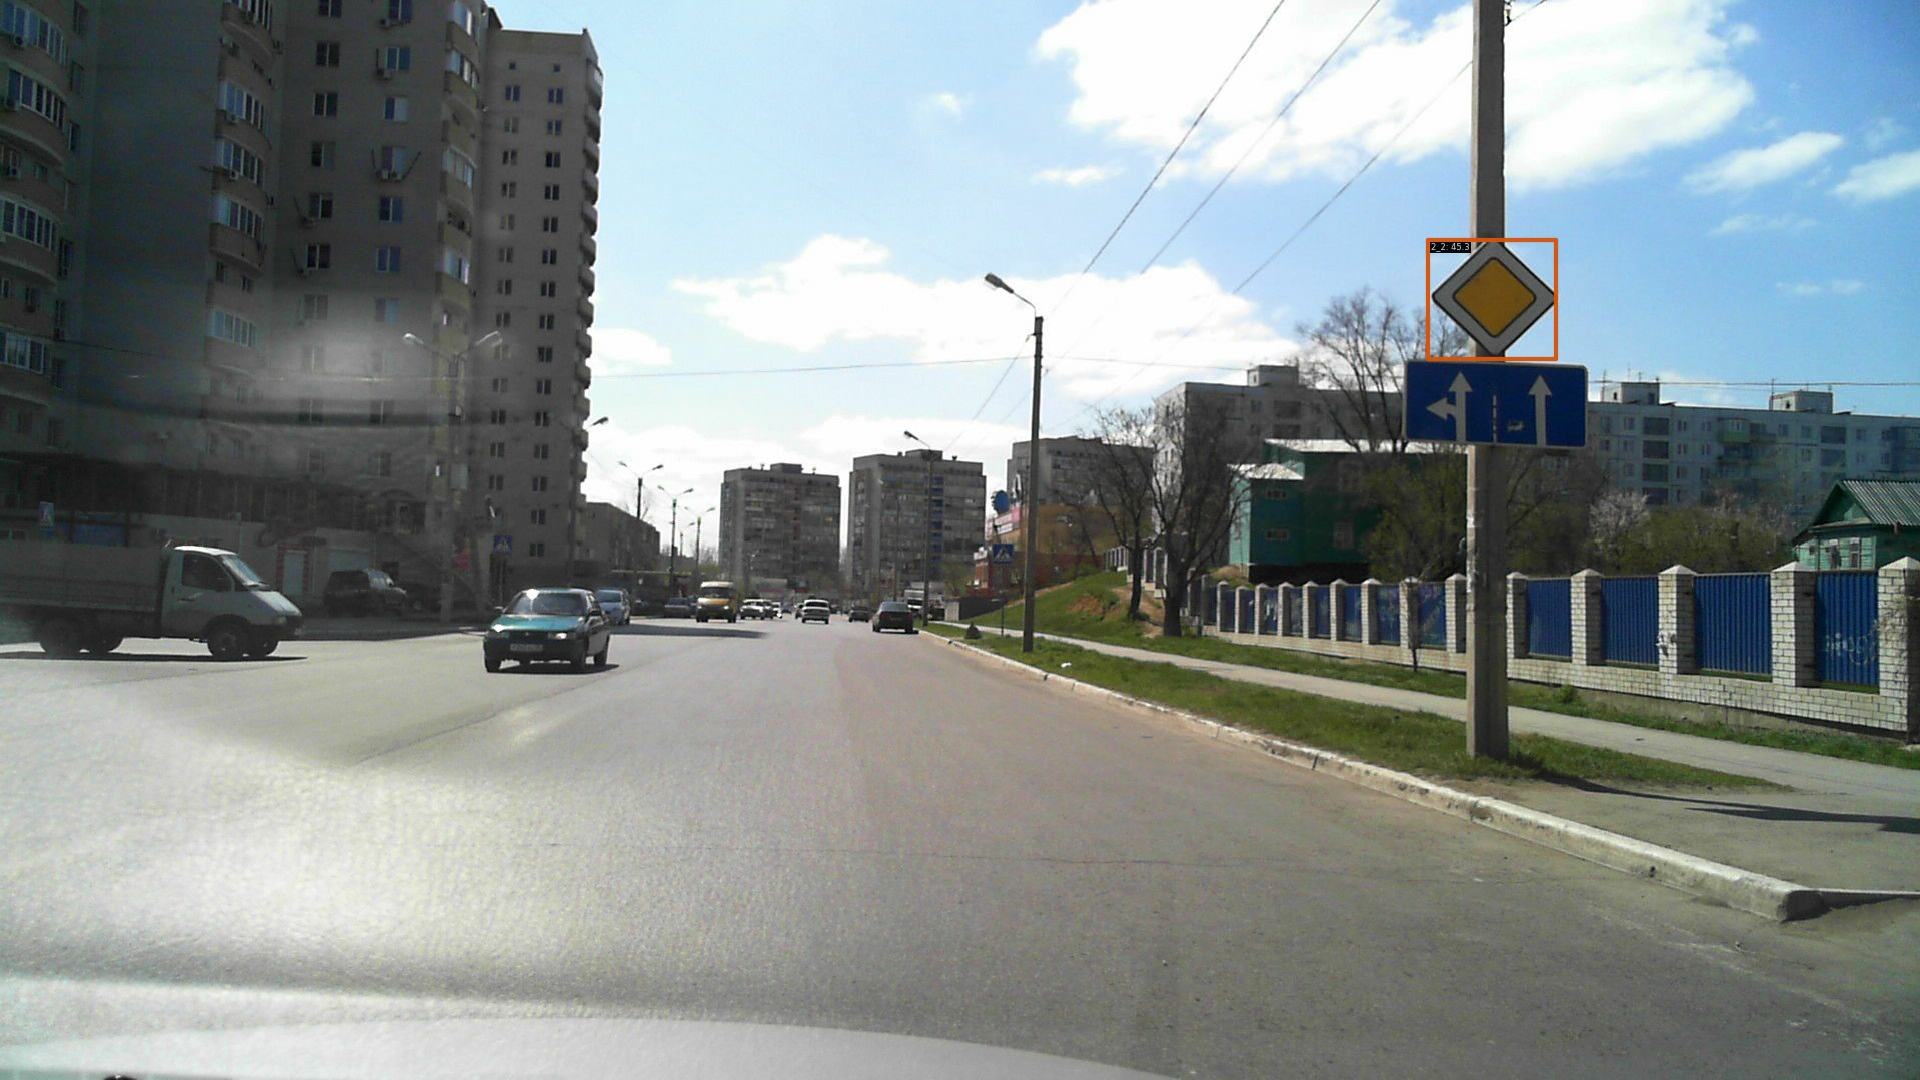

In [163]:
# Show the output image
from PIL import Image

Image.open('/kaggle/working/mmdetection/output/vis/autosave16_04_2013_11_31_55_1.jpg')